In [1]:
!nvidia-smi

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
Sat Aug  3 13:40:24 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.161.08             Driver Version: 535.161.08   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A5000               Off | 00000000:41:00.0 Off |                  Off |
| 30%   29C    P8               9W / 230W |   7384MiB / 24564MiB |      0%      Default |
|                                         |                      |                  

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models, datasets, transforms
from torch.autograd import grad
import torchvision

torch.manual_seed(50)

In [3]:
interval = 30
class_num = 10
protected_layers = []  # No specific layers to protect initially
dst = datasets.CIFAR10("~/.torch", download=True)
tp = transforms.Compose([
    transforms.Resize(32),
    transforms.CenterCrop(32),
    transforms.ToTensor()
])
tt = transforms.ToPILImage()

device = "cpu"
if torch.cuda.is_available():
    device = "cuda:4"  # Changed to cuda:0 for general usage
print("Running on %s" % device)

Files already downloaded and verified
Running on cuda:4


In [4]:
def label_to_onehot(target, num_classes=class_num):
    target = torch.unsqueeze(target, 1)
    onehot_target = torch.zeros(target.size(0), num_classes, device=target.device)
    onehot_target.scatter_(1, target, 1)
    return onehot_target

In [5]:
def cross_entropy_for_onehot(pred, target):
    return torch.mean(torch.sum(- target * F.log_softmax(pred, dim=-1), 1))

In [6]:
  def weights_init(m):
    if hasattr(m, "weight"):
        m.weight.data.uniform_(-0.5, 0.5)
    if hasattr(m, "bias"):
        m.bias.data.uniform_(-0.5, 0.5)

In [7]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        act = nn.Sigmoid
        self.body = nn.Sequential(
            nn.Conv2d(3, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
        )
        self.fc = nn.Sequential(
            nn.Linear(768, class_num)
        )

    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [8]:
net = LeNet().to(device)
net.apply(weights_init)
criterion = cross_entropy_for_onehot

In [9]:
print(net.state_dict())

OrderedDict([('body.0.weight', tensor([[[[-1.8537e-01, -3.5422e-01, -1.5175e-01,  4.4469e-01, -3.9849e-01],
          [ 3.1010e-01, -3.4868e-01, -1.1854e-01,  4.3214e-01, -4.2719e-01],
          [-4.2704e-02,  1.4492e-01,  8.6769e-02, -1.7421e-01,  2.2509e-01],
          [-4.9118e-02, -1.6880e-01, -2.8850e-01, -3.7405e-01, -1.2822e-01],
          [-1.4237e-01,  3.9601e-01,  1.2629e-01,  1.5933e-01, -2.0785e-01]],

         [[ 4.8816e-01,  2.0516e-01, -1.1328e-02, -4.6444e-02,  1.5000e-01],
          [-2.0346e-01, -1.7063e-01,  3.5031e-01,  4.7237e-01,  6.5569e-02],
          [ 1.9640e-01, -4.8058e-01,  4.5993e-01, -4.8770e-01, -1.4281e-01],
          [ 3.1387e-01, -3.9003e-01, -1.8824e-01,  3.5213e-01, -2.3818e-01],
          [ 1.9871e-01, -4.0374e-01, -8.2441e-02, -4.2429e-02,  1.1575e-01]],

         [[-8.2822e-02,  8.5132e-02,  3.0267e-02,  4.1160e-01, -1.7704e-01],
          [ 4.4916e-01,  2.7840e-02, -3.2080e-01,  5.2627e-03,  4.0238e-01],
          [ 2.1002e-01, -4.7378e-01, -1.8

GT label is 2. 
Onehot label is 2.


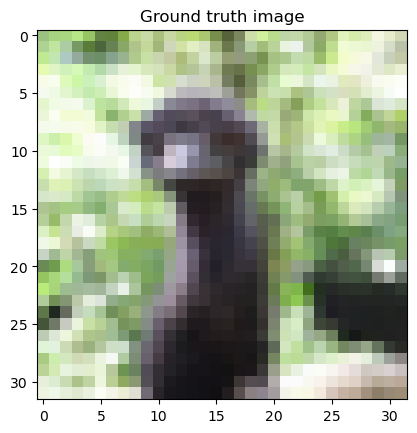

In [10]:
img_index = 55
gt_data = tp(dst[img_index][0]).to(device)
gt_data = gt_data.view(1, *gt_data.size())
gt_label = torch.Tensor([dst[img_index][1]]).long().to(device)
gt_label = gt_label.view(1, )
gt_onehot_label = label_to_onehot(gt_label, num_classes=class_num)
plt.imshow(tt(gt_data[0].cpu()))
plt.title("Ground truth image")
print("GT label is %d." % gt_label.item(), "\nOnehot label is %d." % torch.argmax(gt_onehot_label, dim=-1).item())

In [11]:
out = net(gt_data)
y = criterion(out, gt_onehot_label)
dy_dx = torch.autograd.grad(y, net.parameters())

In [12]:
dy_dx

(tensor([[[[ 1.8593e-01,  1.9325e-01,  2.2289e-01,  1.7075e-01,  1.3550e-01],
           [ 1.6110e-01,  2.0472e-01,  2.5543e-01,  2.0435e-01,  1.6752e-01],
           [ 1.4373e-01,  1.8727e-01,  2.2058e-01,  1.7277e-01,  1.3961e-01],
           [ 1.6131e-01,  1.7491e-01,  1.9686e-01,  1.6018e-01,  1.4122e-01],
           [ 1.5607e-01,  1.7016e-01,  1.9797e-01,  1.6752e-01,  1.5113e-01]],
 
          [[ 2.0367e-01,  2.1795e-01,  2.5555e-01,  1.9852e-01,  1.6337e-01],
           [ 1.7878e-01,  2.2646e-01,  2.8116e-01,  2.2290e-01,  1.8517e-01],
           [ 1.5137e-01,  1.9234e-01,  2.2685e-01,  1.7578e-01,  1.4474e-01],
           [ 1.7056e-01,  1.8191e-01,  2.0312e-01,  1.6769e-01,  1.4640e-01],
           [ 1.7400e-01,  1.9129e-01,  2.1054e-01,  1.7731e-01,  1.6159e-01]],
 
          [[ 1.7488e-01,  1.6774e-01,  1.8179e-01,  1.3981e-01,  1.0017e-01],
           [ 1.4070e-01,  1.8089e-01,  2.2617e-01,  1.7905e-01,  1.4133e-01],
           [ 1.2677e-01,  1.7261e-01,  2.0383e-01,  1.6363

In [13]:
torch.cat([g.view(-1) for g in dy_dx]).count_nonzero()

tensor(19438, device='cuda:4')

In [14]:
dy_dx

(tensor([[[[ 1.8593e-01,  1.9325e-01,  2.2289e-01,  1.7075e-01,  1.3550e-01],
           [ 1.6110e-01,  2.0472e-01,  2.5543e-01,  2.0435e-01,  1.6752e-01],
           [ 1.4373e-01,  1.8727e-01,  2.2058e-01,  1.7277e-01,  1.3961e-01],
           [ 1.6131e-01,  1.7491e-01,  1.9686e-01,  1.6018e-01,  1.4122e-01],
           [ 1.5607e-01,  1.7016e-01,  1.9797e-01,  1.6752e-01,  1.5113e-01]],
 
          [[ 2.0367e-01,  2.1795e-01,  2.5555e-01,  1.9852e-01,  1.6337e-01],
           [ 1.7878e-01,  2.2646e-01,  2.8116e-01,  2.2290e-01,  1.8517e-01],
           [ 1.5137e-01,  1.9234e-01,  2.2685e-01,  1.7578e-01,  1.4474e-01],
           [ 1.7056e-01,  1.8191e-01,  2.0312e-01,  1.6769e-01,  1.4640e-01],
           [ 1.7400e-01,  1.9129e-01,  2.1054e-01,  1.7731e-01,  1.6159e-01]],
 
          [[ 1.7488e-01,  1.6774e-01,  1.8179e-01,  1.3981e-01,  1.0017e-01],
           [ 1.4070e-01,  1.8089e-01,  2.2617e-01,  1.7905e-01,  1.4133e-01],
           [ 1.2677e-01,  1.7261e-01,  2.0383e-01,  1.6363

In [15]:
flattened_grads = torch.cat([g.view(-1) for g in dy_dx])
flattened_grads[-5:]

tensor([6.1626e-04, 4.2538e-05, 3.7137e-04, 1.9220e-03, 8.7746e-04],
       device='cuda:4')

In [16]:
flattened_grads[-4:]

tensor([4.2538e-05, 3.7137e-04, 1.9220e-03, 8.7746e-04], device='cuda:4')

In [17]:
flattened_grads[-3:]

tensor([0.0004, 0.0019, 0.0009], device='cuda:4')

In [18]:
total_params = len(flattened_grads)
exposed_params = int(total_params * (1/3))

In [19]:
total_params

19438

In [20]:
exposed_params

6479

In [21]:
mask = torch.zeros(total_params, device=flattened_grads.device)

In [22]:
mask[:exposed_params] = 1

In [23]:
mask.count_nonzero()

tensor(6479, device='cuda:4')

In [24]:
#mask = mask[torch.randperm(total_params)]

In [25]:
def mask_gradients(dy_dx, exposure_ratio=1/3):
    flattened_grads = torch.cat([g.view(-1) for g in dy_dx])
    total_params = len(flattened_grads)
    exposed_params = int(total_params * exposure_ratio)

    mask = torch.zeros(total_params, device=flattened_grads.device)
    mask[exposed_params:2*exposed_params] = 1

    masked_grads = []
    start = 0
    for g in dy_dx:
        numel = g.numel()
        g_flat = g.view(-1)
        masked_g_flat = g_flat * mask[start:start+numel]
        masked_grads.append(masked_g_flat.view_as(g))
        start += numel

    return tuple(masked_grads)


In [26]:
dy_dx = mask_gradients(dy_dx)

In [27]:
original_dy_dx = list((_.detach().clone() for _ in dy_dx))

Dummy label is 7.


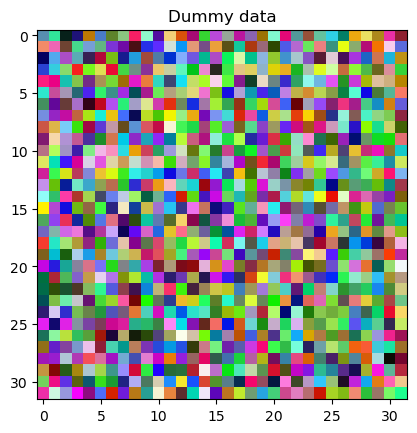

In [28]:
dummy_data = torch.randn(gt_data.size()).to(device).requires_grad_(True)
dummy_label = torch.randn(gt_onehot_label.size()).to(device).requires_grad_(True)

plt.imshow(tt(dummy_data[0].cpu()))
plt.title("Dummy data")
print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())

In [29]:
optimizer = torch.optim.LBFGS([dummy_data, dummy_label])

In [30]:
history = []
losses = []
for iters in range(30*interval):
    def closure():
        optimizer.zero_grad()

        pred = net(dummy_data)
        dummy_onehot_label = F.softmax(dummy_label, dim=-1)
        dummy_loss = criterion(pred, dummy_onehot_label)
        dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)

        dummy_dy_dx = mask_gradients(dummy_dy_dx)

        grad_diff = 0
        grad_count = 0

        for gx, gy in zip(dummy_dy_dx, original_dy_dx):
            grad_diff += ((gx - gy) ** 2).sum()
            grad_count += gx.nelement()

        grad_diff.backward()
        losses.append(grad_diff.item())
        return grad_diff

    optimizer.step(closure)
    if iters % interval == 0:
        print(f"{iters}, {losses[iters]}")
    history.append(tt(dummy_data[0].cpu()))

plt.figure(figsize=(12, 8))

0, 126.19233703613281
30, 0.7055870294570923
60, 0.17589843273162842
90, 0.09078347682952881
120, 0.064411960542202
150, 0.048714183270931244
180, 0.039376724511384964
210, 0.03291119635105133
240, 0.026898540556430817
270, 0.02168932370841503
300, 0.016688412055373192
330, 0.01548226922750473
360, 0.014830133877694607
390, 0.014203258790075779
420, 0.013690006919205189
450, 0.013251972384750843
480, 0.012817859649658203
510, 0.01233755238354206
540, 0.011837168596684933
570, 0.011387252248823643
600, 0.010899366810917854
630, 0.010335739701986313
660, 0.009605073370039463
690, 0.008670483715832233
720, 0.007474982645362616
750, 0.006776639260351658
780, 0.006330643780529499
810, 0.006116854026913643
840, 0.005929504055529833
870, 0.005729230586439371


<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

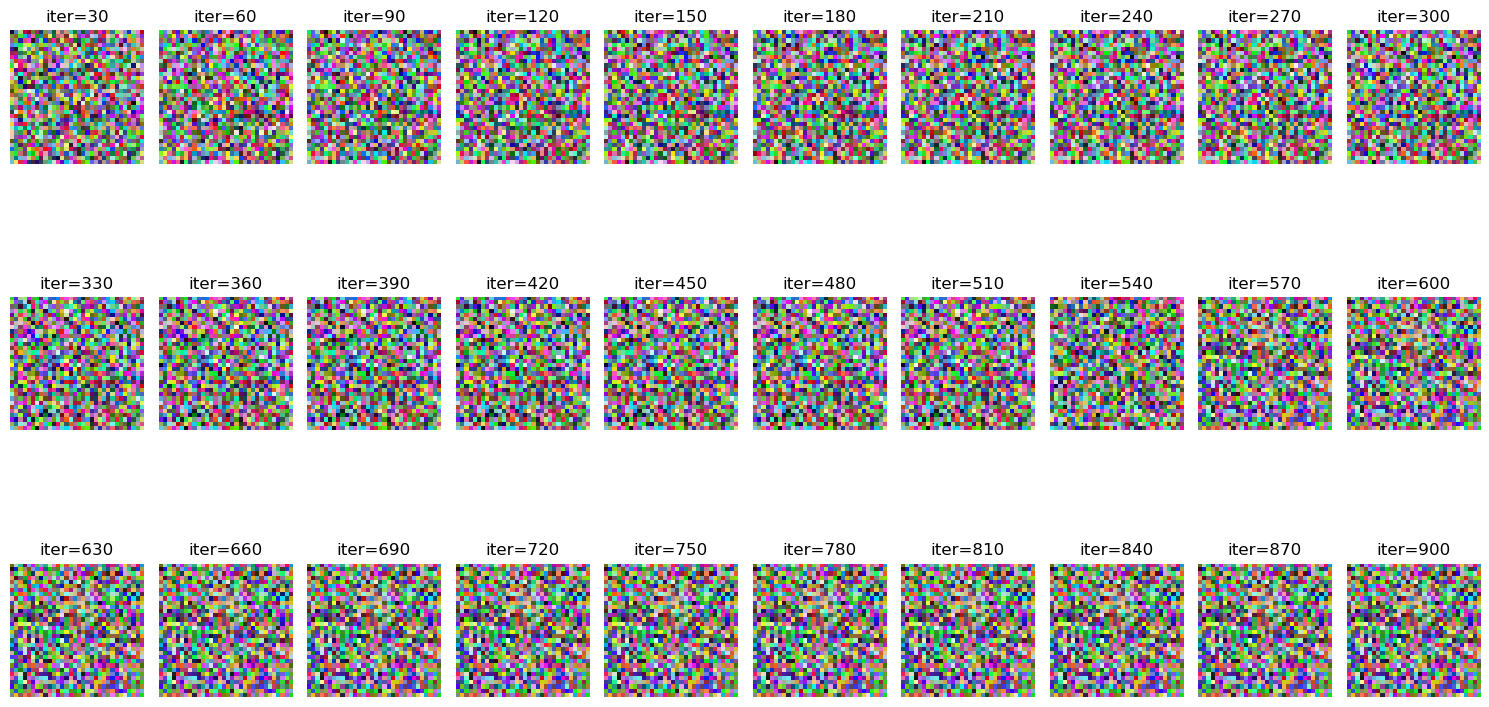

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data: replace this with your actual image data
# For demonstration, let's generate 900 random images (28x28 pixels)
# history = np.random.rand(900, 28, 28)

# Set the interval
interval = 30

# Create a figure
plt.figure(figsize=(15, 9))

for i in range(30):
    ite_num = i * interval + interval - 1
    plt.subplot(3, 10, i + 1)
    plt.imshow(history[ite_num])  # Assuming the images are grayscale
    plt.title("iter=%d" % (ite_num + 1))
    plt.axis('off')

# Show the plot
plt.tight_layout()
plt.show()


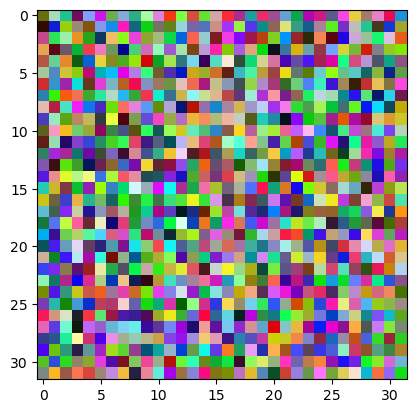

In [32]:
plt.imshow(history[869])
# plt.title("iter=%d" % (ite_num+1))
plt.show()

In [33]:
print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())

Dummy label is 2.


idx = 898, len = 12271
Dummy label is 2.


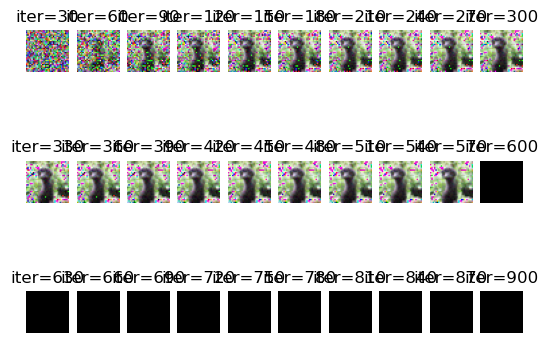

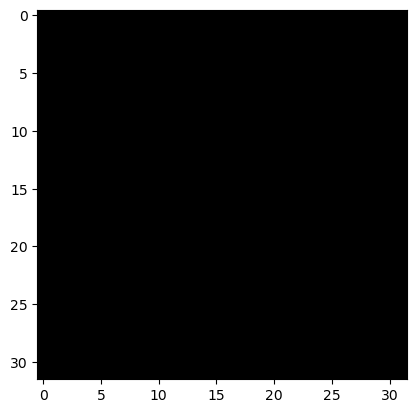

In [68]:
for i in range(30):
    ite_num = i * interval + interval - 1
    plt.subplot(3, 10, i + 1)
    plt.imshow(history[ite_num])
    plt.title("iter=%d" % (ite_num+1))
    plt.axis('off')

filename = 'CIFAR'+str(class_num)+'_'+ str(30*interval) + 'ite_' + str(protected_layers) + '_' +'.png'
plt.savefig(filename)

plt.figure()
loss = min(losses[0:interval * 30 - 1])
idx = losses.index(loss)
print(f"idx = {idx}, len = {len(losses)}")
plt.imshow(history[idx])
filename = 'single_' + filename
plt.savefig(filename)

print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())

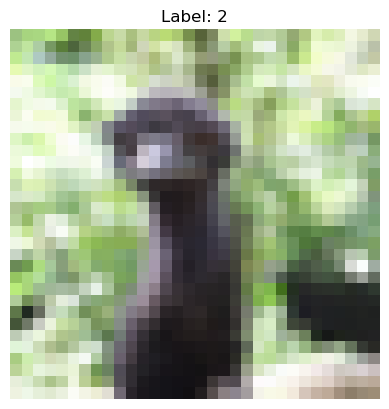

In [16]:
# Get a sample image and its label
image, label = dst[55]

# Display the image using matplotlib
plt.imshow(image)
plt.title(f"Label: {label}")
plt.axis('off')  # Hide axes
plt.show()

GT label is 2. 
Onehot label is 2.


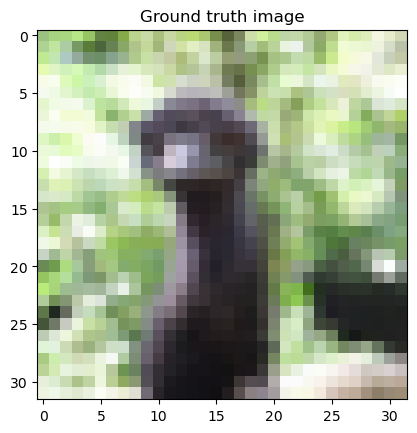

In [17]:
plt.imshow(tt(gt_data[0].cpu()))
# file_gt = "gt.png"
# plt.savefig(file_gt)
plt.title("Ground truth image")
print("GT label is %d." % gt_label.item(), "\nOnehot label is %d." % torch.argmax(gt_onehot_label, dim=-1).item())